In [74]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import register_keras_serializable
from PIL import Image
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [56]:
# Function load image in format .tif
def load_images(folder_path):
    """
    Loads all images from the specified folder and returns a list of image objects.
    
    Args:
    - folder_path (str): Path to the folder containing the images.
    
    Returns:
    - List of Image objects: List of loaded image 
    """
    image_list = []
    
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith('.png'):
            file_path = os.path.join(folder_path, file_name)
            try:
                image = Image.open(file_path)
                image_list.append(image)
            except PIL.UnidentifiedImageError as e:
                print(f"Error in file {filename}: {e}")
    
    return image_list

In [57]:
# Path to image and mask folder
path_image_origin = "/kaggle/input/cvcclinicdb/PNG/Original"
path_image_mask = "/kaggle/input/cvcclinicdb/PNG/Ground Truth"

In [58]:
# Load image and mask
image_contain = load_images(path_image_origin)
mask_contain = load_images(path_image_mask)

In [59]:
# Create Tensorflow dataset
def generator():
    for img, msk in zip(image_contain, mask_contain):
        yield np.array(img), np.array(msk)
        
dataset_pre = tf.data.Dataset.from_generator(generator, 
                                         output_signature=(
                                             tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
                                             tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8)
                                         ))
dataset_pre = dataset_pre.apply(tf.data.experimental.assert_cardinality(len(image_contain)))

In [60]:
print(dataset_pre.element_spec)

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None))


In [61]:
for img,msk in dataset_pre.take(1):
    print("Image shape:", img.shape)  # Should be (height, width, 3)
    print("Mask shape:", msk.shape)  # Should be (height, width)

Image shape: (288, 384, 3)
Mask shape: (288, 384, 3)


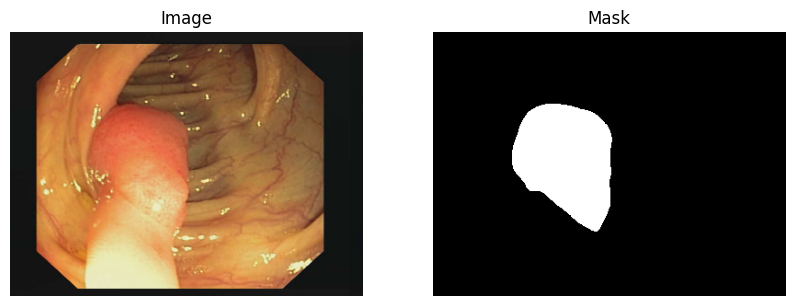

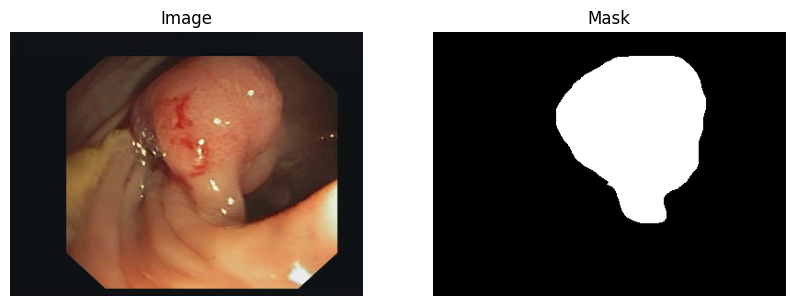

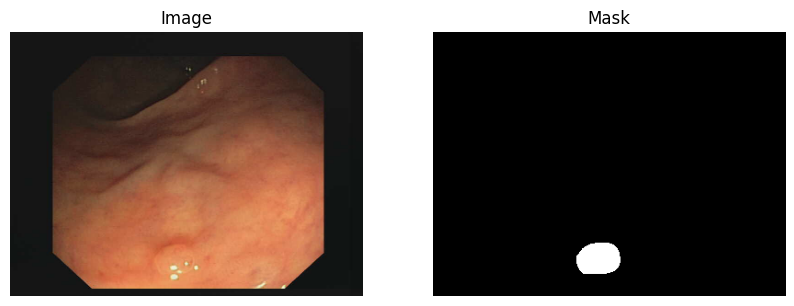

In [62]:
# Visualize dataset
for i, (img, msk) in enumerate(dataset_pre.take(3)):
    plt.figure(figsize=(10, 5))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img.numpy())
    plt.title("Image")
    plt.axis("off")

    # Show mask
    plt.subplot(1, 2, 2)
    plt.imshow(msk.numpy())
    plt.title("Mask")
    plt.axis("off")

    plt.show()

In [63]:
# Data preparation: normalizatio, augumentation, encoding
def prepare_data (dataset, test_check = False):
    def preprocess(img, msk):
        img = tf.image.resize(img, (256, 256))
        msk = tf.image.resize(msk, (256, 256))
        msk = tf.image.rgb_to_grayscale(msk)
        # Normalization
        img = tf.cast(img, tf.float32) / 255.0
        msk = tf.cast(msk > 0.5, tf.float32)
        return img, msk
        
    def augment(img, msk):
        img, msk = preprocess(img, msk)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)  # Điều chỉnh độ sáng ngẫu nhiên
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)  # Điều chỉnh độ tương phản ngẫu nhiên
        return img, msk
    
    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    if test_check == False:
        dataset = dataset.repeat().batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [64]:
# Split dataset into train, test, val
def split_data(dataset, train_ratio):
    """Split the dataset into training, validation, and test sets."""
    total_size = tf.data.experimental.cardinality(dataset).numpy()
    test_size = int(0.1 * total_size)
    train_size = int(train_ratio * (total_size - test_size))

    test_data = dataset.take(test_size)
    train_val_data = dataset.skip(test_size)
    train_data = train_val_data.take(train_size)
    val_data = train_val_data.skip(train_size)

    return train_data, val_data, test_data

train_data_pre, val_data_pre, test_data_pre = split_data(dataset_pre, 0.8)

In [65]:
train_data = prepare_data(train_data_pre, False)
val_data = prepare_data(val_data_pre, False)
test_data = prepare_data(test_data_pre, True)

In [66]:
# U-net Architechture
def downsampling_block(inputs, n_filters, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block.
    
    Args:
        inputs: Input tensor.
        n_filters: Number of filters for convolutional layers.
        dropout_prob: Dropout probability.
        max_pooling: Whether to apply max pooling.

    Returns:
        next_layer: Output tensor for the next layer.
        skip_connection: Skip connection tensor.
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    next_layer = MaxPooling2D(pool_size=(2, 2))(conv) if max_pooling else conv
    return next_layer, conv

In [67]:
def upsampling_block(expansive_input, contractive_input, n_filters):
    """
    Convolutional upsampling block.

    Args:
        expansive_input: Input tensor from previous layer.
        contractive_input: Skip connection tensor from encoding path.
        n_filters: Number of filters for convolutional layers.

    Returns:
        Output tensor after upsampling and convolution.
    """
    up = Conv2DTranspose(n_filters, 3, strides=(2, 2), padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

In [68]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1):
    """
    U-Net model implementation.

    Args:
        input_size: Shape of the input tensor.
        n_filters: Number of filters for the convolutional layers.
        n_classes: Number of output classes.

    Returns:
        U-Net model.
    """
    inputs = Input(input_size)

    # Contracting Path (Encoder)
    dblock1 = downsampling_block(inputs, n_filters)
    dblock2 = downsampling_block(dblock1[0], n_filters * 2)
    dblock3 = downsampling_block(dblock2[0], n_filters * 4)
    dblock4 = downsampling_block(dblock3[0], n_filters * 8)
    dblock5 = downsampling_block(dblock4[0], n_filters * 16)
    #Bottleneck
    bblock6 = downsampling_block(dblock5[0], n_filters * 32, dropout_prob=0.4, max_pooling=False)

    # Expanding Path (Decoder)
    ublock7 = upsampling_block(bblock6[0], dblock5[1], n_filters * 16)
    ublock8 = upsampling_block(ublock7, dblock4[1], n_filters * 8)
    ublock9 = upsampling_block(ublock8, dblock3[1], n_filters * 4)
    ublock10 = upsampling_block(ublock9, dblock2[1], n_filters * 2)
    ublock11 = upsampling_block(ublock10, dblock1[1], n_filters)

    # Output Layer
    conv12 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock11)
    outputs = Conv2D(n_classes, 1, activation="sigmoid", padding="same")(conv12)

    return Model(inputs=inputs, outputs=outputs)

In [69]:
model = unet_model(n_filters=32)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_48[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 128, 128, 32)   │              0 │ conv2d_49[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 64, 64, 64)     │              0 │ conv2d_51[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 32, 32, 128)    │              0 │ conv2d_53[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 16, 16, 256)    │              0 │ conv2d_55[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 8, 8, 512)      │              0 │ conv2d_57[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)   

 Total params: 34,595,585 (131.97 MB)

 Trainable params: 34,595,585 (131.97 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Define loss function
@register_keras_serializable()
def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    iou = tf.where(K.equal(union, 0), 0.0, intersection / union)
    return iou
@register_keras_serializable()
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
@register_keras_serializable()
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
@register_keras_serializable()
def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce

In [76]:
# Training U-net
metric = ["accuracy", iou_metric]
steps_per_epoch = tf.data.experimental.cardinality(train_data_pre).numpy() // 16
validation_steps = tf.data.experimental.cardinality(val_data_pre).numpy() // 16

In [77]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics = metric)

In [78]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    min_lr=1e-5,
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,                
    restore_best_weights=True  
)

In [79]:
history = model.fit(train_data, 
                    validation_data=val_data,
                    epochs=50,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - accuracy: 0.9081 - iou_metric: 0.0668 - loss: 0.6990 - val_accuracy: 0.8962 - val_iou_metric: 0.1231 - val_loss: 0.6318 - learning_rate: 1.0000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.9041 - iou_metric: 0.1255 - loss: 0.6004 - val_accuracy: 0.7711 - val_iou_metric: 0.1496 - val_loss: 0.5990 - learning_rate: 1.0000e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.8511 - iou_metric: 0.1443 - loss: 0.5799 - val_accuracy: 0.8566 - val_iou_metric: 0.1837 - val_loss: 0.5362 - learning_rate: 1.0000e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.8621 - iou_metric: 0.1652 - loss: 0.5535 - val_accuracy: 0.8659 - val_iou_metric: 0.1953 - val_loss: 0.5204 - learning_rate: 1.0000e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8750 - iou_metric: 0.1829 - loss: 0.5320 - val_accuracy: 0.8550 - val_iou_metric: 0.2402 - val_loss: 0.4963 - learning_rate: 

In [80]:
_, _, test_iou = model.evaluate(test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.9612 - iou_metric: 0.6152 - loss: 0.2075


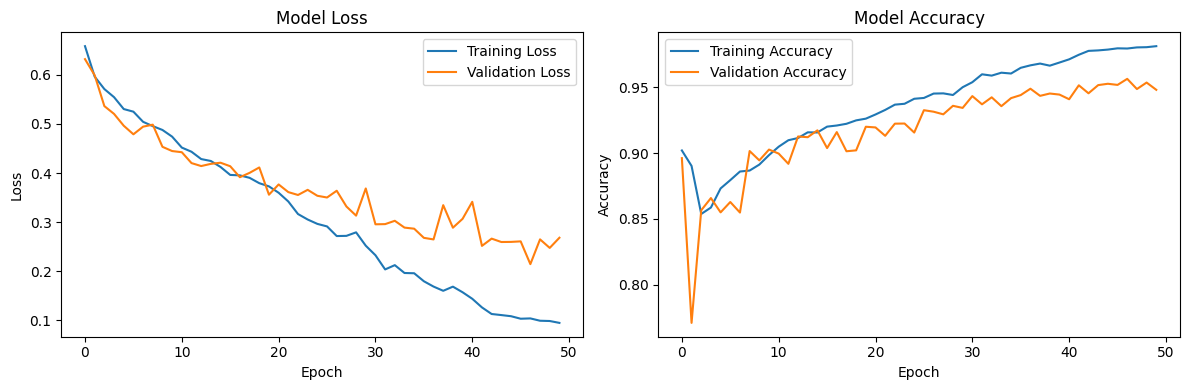

In [81]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss graph
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Accuracy graph
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


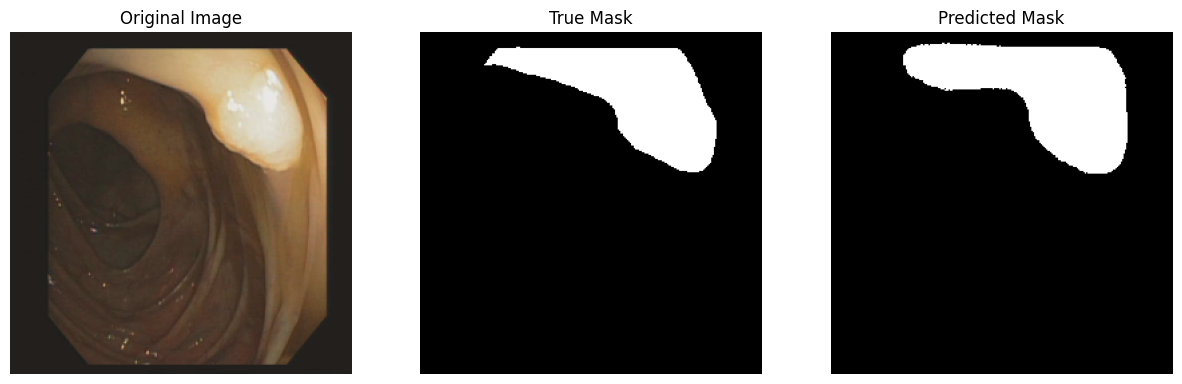

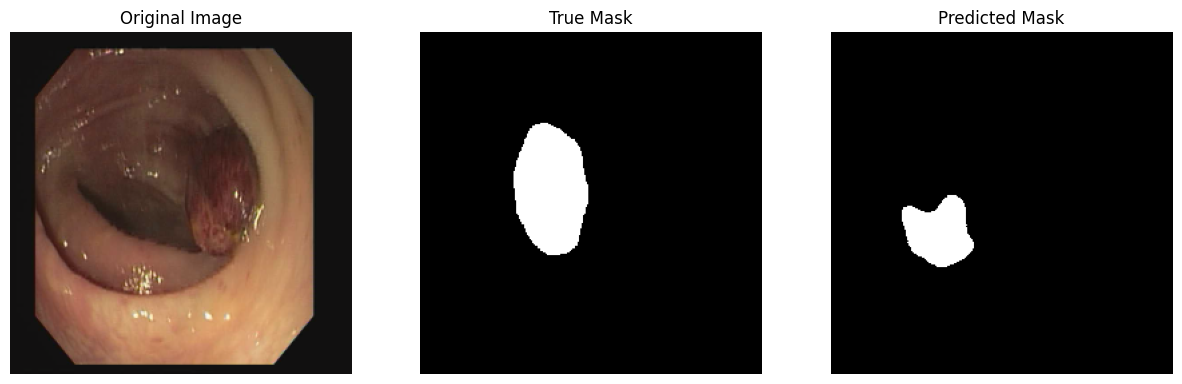

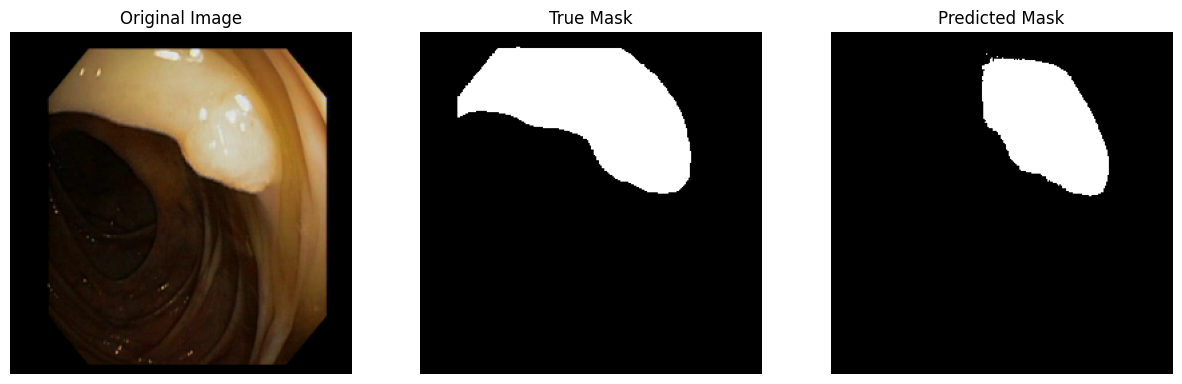

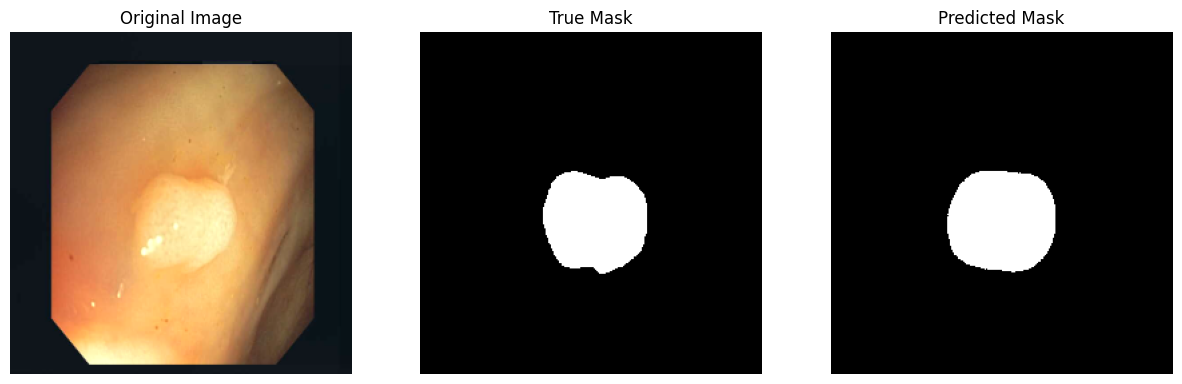

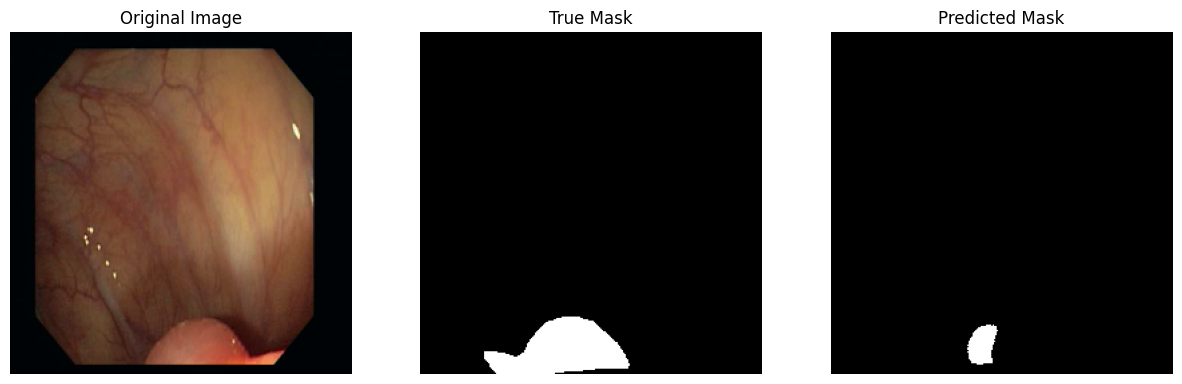

In [90]:
def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
    # Select a random batch
    random_batch = random.choice(list(dataset))
    images, masks = random_batch

    # Select random indices for num_samples
    indices = random.sample(range(len(images)), min(num_samples, len(images)))

    predictions = model.predict(images)

    # Binarizing prediction masks
    binary_predictions = (predictions > threshold).astype('uint8')

    for i in indices:
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        # True mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(binary_predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

visualize_predictions(model, test_data, num_samples=5)

In [101]:
model.save('/kaggle/working/model.h5')
model.save('/kaggle/working/model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


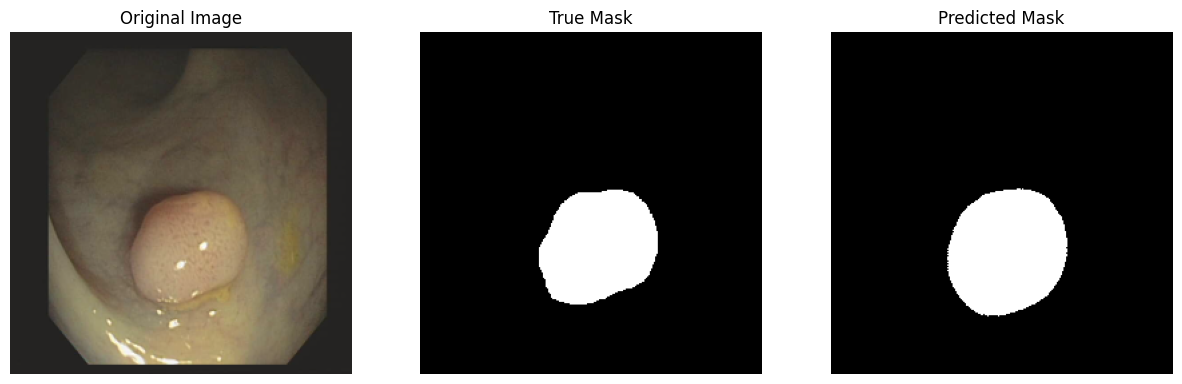

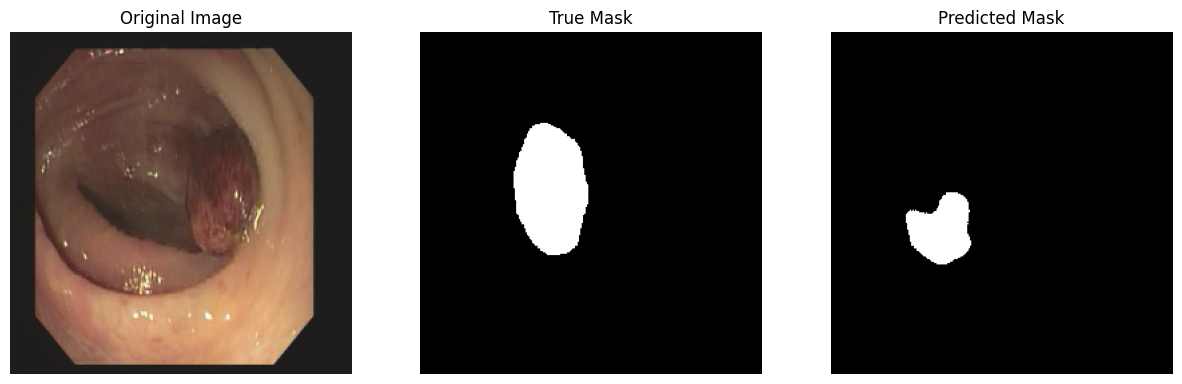

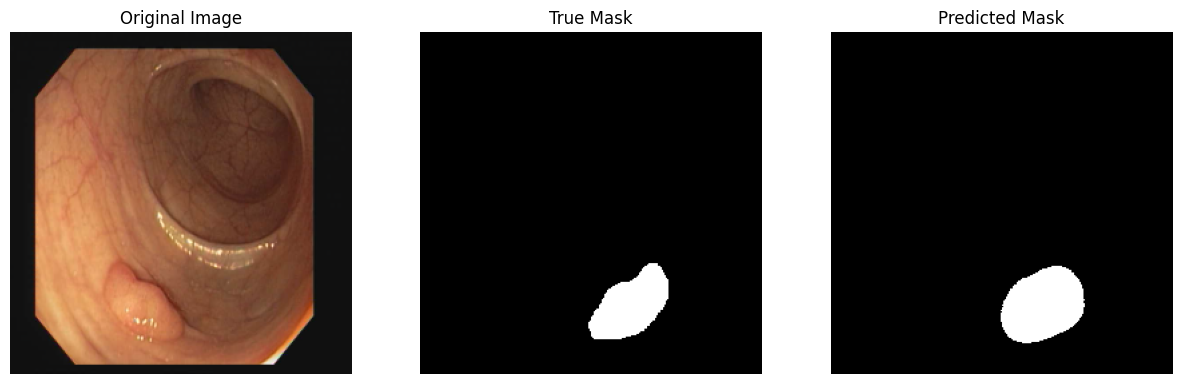

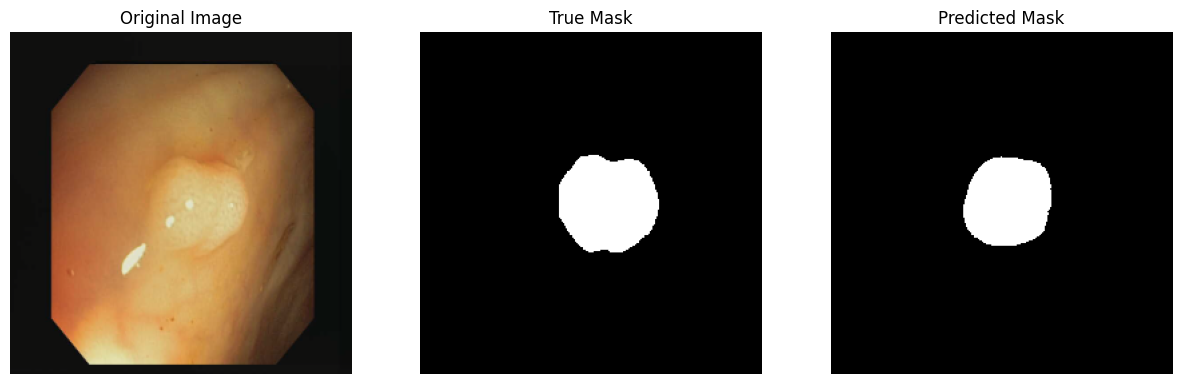

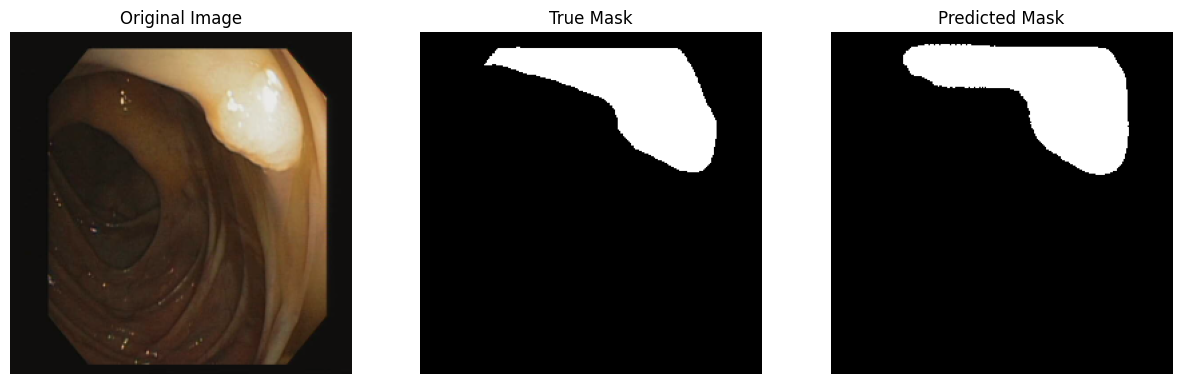

In [100]:
model_load = tf.keras.models.load_model('/kaggle/working/model.h5')

visualize_predictions(model_load, test_data, num_samples=5)

In [89]:
from IPython.display import FileLink

FileLink('/kaggle/working/model_final.h5')  

/kaggle/working/model_final.h5